# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
## 1. Feature Extraction

In [12]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from skimage.feature import hog

# These functions were based on functions from Udacity's Self-Driving Car Nanodegree Object Detection lesson
# with minor changes.

# Function to compute spatially binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Function to compute color histogram features  
def color_hist(img, nbins=32):
        
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Uncomment to visualize color histograms.
#     bin_edges = channel1_hist[1]
#     bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

#     fig = plt.figure(figsize=(12,3))
#     plt.subplot(131)
#     plt.bar(bin_centers, channel1_hist[0])
#     plt.title('Channel 1 Histogram')
#     plt.subplot(132)
#     plt.bar(bin_centers, channel2_hist[0])
#     plt.title('Channel 2 Histogram')
#     plt.subplot(133)
#     plt.bar(bin_centers, channel3_hist[0])
#     plt.title('Channel 3 Histogram')

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, 
                     feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise return one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_file in imgs:
        # Read in each one by one
        img = mpimg.imread(img_file)
        # Apply color conversion if other than 'RGB'
        if cspace is 'HSV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_img, spatial_size)
        # Apply color_hist() to get color histogram features
        color_features = color_hist(feature_img, hist_bins)
        # Apply get_hog_features() to get hog features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_img.shape[2]):
                hog_features.append(get_hog_features(feature_img[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_img[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, color_features, hog_features)))
    # Return list of feature vectors
    return features

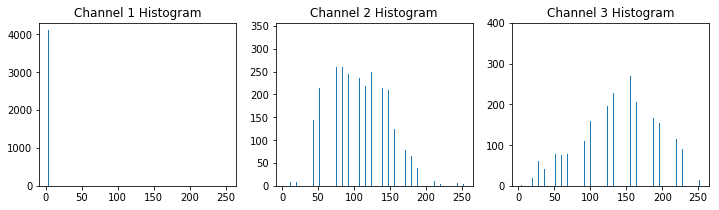

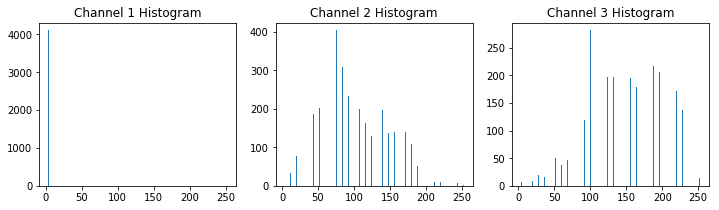

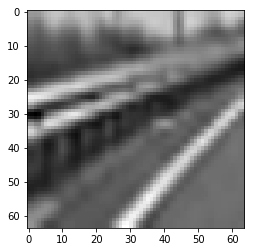

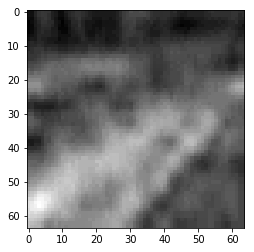

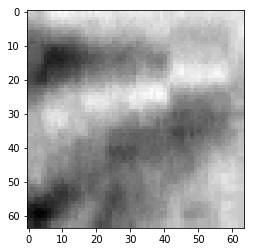

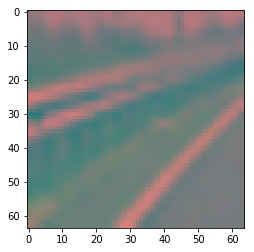

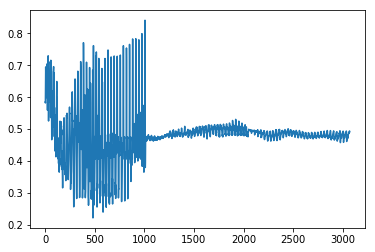

In [198]:
# This code block is for testing and visualizing individual features
car_img = mpimg.imread('vehicles/GTI_Far/image0007.png')
non_car_img = mpimg.imread('non-vehicles/GTI/image8.png')

car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
non_car_img = cv2.cvtColor(non_car_img, cv2.COLOR_RGB2YCrCb)

car_spatial = bin_spatial(car_img)
car_hist = color_hist(car_img)

non_car_spatial = bin_spatial(non_car_img)
non_car_hist = color_hist(non_car_img)

features, car_hog_img1 = get_hog_features(car_img[:,:,0], orient=9, pix_per_cell=2, cell_per_block=2, 
                                          vis=True, feature_vec=True)
features, car_hog_img2 = get_hog_features(car_img[:,:,1], orient=9, pix_per_cell=2, cell_per_block=2, 
                                          vis=True, feature_vec=True)
features, car_hog_img3 = get_hog_features(car_img[:,:,2], orient=9, pix_per_cell=2, cell_per_block=2, 
                                          vis=True, feature_vec=True)
features, non_car_hog_img1 = get_hog_features(non_car_img[:,:,0], orient=9, pix_per_cell=2, cell_per_block=2, 
                                          vis=True, feature_vec=True)
features, non_car_hog_img2 = get_hog_features(non_car_img[:,:,1], orient=9, pix_per_cell=2, cell_per_block=2, 
                                          vis=True, feature_vec=True)
features, non_car_hog_img3 = get_hog_features(non_car_img[:,:,2], orient=9, pix_per_cell=2, cell_per_block=2, 
                                          vis=True, feature_vec=True)
plt.figure()
plt.imshow(non_car_img[:,:,0], cmap='gray')
plt.figure()
plt.imshow(non_car_img[:,:,1], cmap='gray')
plt.figure()
plt.imshow(non_car_img[:,:,2], cmap='gray')
plt.figure()
plt.imshow(non_car_img)
plt.figure()
plt.plot(non_car_spatial)

## 2. Train a Linear SVM Classifier

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn import grid_search

# This function was based on code from Udacity's Self-Driving Car Nanodegree Object Detection lesson
# with minor changes.

# Train a Linear SVM classifier with positive and negative class features.
def train_svm_classifier(pos_features, neg_features):
    # Create an array stack of feature vectors
    X = np.vstack((pos_features, neg_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(pos_features)), np.zeros(len(neg_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Use a linear SVC 
    svc = LinearSVC()
    # Parameter search for the best C value
    svc = grid_search.GridSearchCV(svc, {'C':[0.1,0.5,1,5,10]})
    svc.fit(X_train, y_train)
    
    # Check the score of the SVC
    print('Best C was = ', svc.best_params_)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return X_scaler, svc

In [147]:
# # This code block processes Udacity data to augment image training set
# import pandas as pd

# sample_img = mpimg.imread(vehicle_images[0])
# udacity_data = pd.read_csv('labels_crowdai.csv', sep=',',header=None)
# car_data = udacity_data.loc[udacity_data[5] == 'Pedestrian']
# for index, row in car_data.iterrows():
#     img = cv2.imread('object-detection-crowdai/' + str(row[4]))
#     if (int(row[3]) <= int(row[1]) or int(row[2]) <= int(row[0])):
#         continue
#     vehicle = img[int(row[1]):int(row[3]),int(row[0]):int(row[2])]
#     vehicle = cv2.resize(vehicle, (64,64))
#     cv2.imwrite('non-vehicles/udacity_data/' + str(row[4]), vehicle)

In [4]:
import glob

# Read in GTI and KITTI data
vehicle_images = glob.glob('vehicles/GTI_Far/*.png')
vehicle_images += glob.glob('vehicles/GTI_Left/*.png')
vehicle_images += glob.glob('vehicles/GTI_MiddleClose/*.png')
vehicle_images += glob.glob('vehicles/GTI_Right/*.png')
vehicle_images += glob.glob('vehicles/KITTI_extracted/*.png')
#vehicle_images += glob.glob('vehicles/udacity_data/*.jpg')

non_vehicle_images = glob.glob('non-vehicles/Extras/*.png')
non_vehicle_images += glob.glob('non-vehicles/GTI/*.png')
#non_vehicle_images += glob.glob('non-vehicles/udacity_data/*.jpg')

print(len(vehicle_images))
print(len(non_vehicle_images))

# Extract features from the training set and train the Linear SVM classifier
pos_features = extract_features(vehicle_images, cspace='YCrCb', hog_channel='ALL')
neg_features = extract_features(non_vehicle_images, cspace='YCrCb', hog_channel='ALL')
X_scaler, svc = train_svm_classifier(pos_features, neg_features)

8792
8968
Best C was =  {'C': 0.1}
Test Accuracy of SVC =  0.9944


## 3. Implement Sliding Window

In [5]:
# This function was based on code from Udacity's Self-Driving Car Nanodegree Object Detection lesson
# with minor changes.
# Define a single function that can extract features using HOG sub-sampling
def sliding_window_search(img, ystart, ystop, svc, X_scaler, scale=1, orient=9, pix_per_cell=8, cell_per_block=2, 
                          spatial_size=(32,32), hist_bins=32, cspace='RGB'):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_to_search = img[ystart:ystop,:,:]
    # Apply color conversion if other than 'RGB'
    if cspace is 'HSV':
        cimg_to_search = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2HSV)
    elif cspace is 'LUV':
        cimg_to_search = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2LUV)
    elif cspace is 'HLS':
        cimg_to_search = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2HLS)
    elif cspace is 'YUV':
        cimg_to_search = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2YUV)
    elif cspace is 'YCrCb':
        cimg_to_search = cv2.cvtColor(img_to_search, cv2.COLOR_RGB2YCrCb)
    
    # Scale the image
    if scale != 1:
        img_shape = cimg_to_search.shape
        cimg_to_search = cv2.resize(cimg_to_search, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
        
    ch1 = cimg_to_search[:,:,0]
    ch2 = cimg_to_search[:,:,1]
    ch3 = cimg_to_search[:,:,2]

    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(cimg_to_search[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            color_features = color_hist(subimg, hist_bins)
            
            # Scale features and make a prediction
            features = np.hstack(np.concatenate((spatial_features, color_features, hog_features)))
            test_features = X_scaler.transform(features)  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img,bbox[0],bbox[1],(0,0,255),6)
                bbox_list.append(bbox)
                
    return bbox_list, draw_img

## 4. Create a Heatmap to Reject Outliers

In [6]:
# These functions were based on functions from Udacity's Self-Driving Car Nanodegree Object Detection lesson
# with minor changes.

# Update the heatmap
def update_heat(heatmap, bbox_list, threshold):
    for box in bbox_list:
        # Add 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Zero out areas of the heatmap below a threshold
def apply_heatmap_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Draw filtered bounding boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## 5. Run the Pipeline on a Video Stream

In [14]:
# This code block runs the entire vehicle detection pipeline on a video stream.
from moviepy.editor import VideoFileClip, ImageSequenceClip
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
%matplotlib inline

# Input video stream
project_video = VideoFileClip("project_video.mp4")

# Define region of interest where searching will be done
ystart = 400
ystop = 656

# Heatmap threshold
heatmap_threshold = 2

images_list = []
counter = 0
for img in project_video.iter_frames():
#for img_file in glob.glob('test_images/*.jpg'):
    #img = mpimg.imread(img_file)
    counter = counter + 1
    print(counter)
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        
    # Find cars
    bbox_list1, draw_image1 = sliding_window_search(img, ystart, ystop, svc, X_scaler, scale=1, cspace='YCrCb')
    bbox_list15, draw_image2 = sliding_window_search(img, ystart, ystop, svc, X_scaler, scale=1.5, cspace='YCrCb')
    bbox_list2, draw_image3 = sliding_window_search(img, ystart, ystop, svc, X_scaler, scale=2, cspace='YCrCb')
    
    # Update heatmap
    bbox_list = bbox_list1 + bbox_list15 + bbox_list2
    #print(bbox_list)
    heatmap = update_heat(heatmap, bbox_list, heatmap_threshold)
    heatmap = apply_heatmap_threshold(heatmap, heatmap_threshold)
    
    # Visualize the heatmap    
    #heatmap = np.clip(heatmap, 0, 255)
    #plt.figure()
    #plt.imshow(heatmap, cmap='hot')
    
    # Find labels from heatmap
    labels = label(heatmap)
    #plt.figure()
    #plt.imshow(labels[0], cmap='gray')
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    #draw_img_test = np.copy(img)
    #for bbox in bbox_list:
        #cv2.rectangle(draw_img_test,bbox[0],bbox[1],(0,0,255),6)
    #plt.figure()
    #plt.imshow(draw_img_test)
    #plt.figure()
    #plt.imshow(draw_img)
    images_list.append(draw_img)
    
# Write the output video
video_output = 'vehicle_detection_project_video.mp4'
lane_clip = ImageSequenceClip(images_list, project_video.fps)
lane_clip.write_videofile(video_output, audio=False)
    

1
2


KeyboardInterrupt: 